In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import trange as notebook_trange
from tqdm import tqdm, trange
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score

from pycaret.classification import*
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("cardio_train.csv",sep=";")
print(f"Size of Dataset: {df.shape}")
df.head()

Size of Dataset: (70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


So, this Dataset contains the following Features :

    id => It's just the Id no of the row. Not revelant
    age => It's the age of a person in Days
    gender => It's the gender of the person
    height => It's the height of the person in cm
    weight => It's the weight of the person in kg
    ap_hi => It's the Systolic blood pressure i.e. Pressure exerted when Blood is ejected in arteries. Normal value : 120mmhg or Below
    ap_low => It's the Diastolic blood pressure i.e. Pressure exerted when Blood exerts between arteries and heartbeats. Normal Value : 80mmhg or Below
    cholesterol :> It's the Cholestreol value (Cholesterol is a type of fat found in your blood) of your blood. In Adults, 200 mg/dL is desired with 200 and 239 mg/dL as Boderline High. In Children, 170 mg/dL is desired with 170 and 199 mg/dL as Boderline High
    gluc => It's the Glucose Level. They're less than 100 mg/dL after not eating (fasting) for at least 8 hours. And they're less than 140 mg/dL 2 hours after eating. For most people without diabetes, blood sugar levels before meals hover around 70 to 80 mg/dL
    smoke => It contain Binary Values stating whether Person is a Smoker or not i.e. {0 : 'Not a Smoker', 1 : 'Smoker'}
    alco => It contain Binary Values stating whether Person is an alchoalic or not i.e. {0 : 'Not a Alcholic', 1 : 'Alcholic'}
    active => It contain Binary Values stating whether Person is involved in physical activites or not i.e. {0 : 'Not involved in Physical Activites', 1 : 'involved in physical activites'}
    cardio => It's our Target Value Binary Values stating whether Person has Cardiovascular diseases (CVDs) or Not i.e. {0 : 'Not Have CVD', 1 : 'Have CVD'}


In [3]:
duplicate_sum = df.duplicated().sum()
if duplicate_sum:
    print('Duplicates Rows in Dataset are : {}'.format(duplicate_sum))
else:
    print('Dataset contains no Duplicate Values')

Dataset contains no Duplicate Values


In [4]:
# Seeking to outlier then destroy it!!!
def outliers(df_out, drop = False):
    for each_feature in df_out.columns:
        feature_data = df_out[each_feature]
        Q1 = np.percentile(feature_data, 25.) # 25th percentile of the data of the given feature
        Q3 = np.percentile(feature_data, 75.) # 75th percentile of the data of the given feature
        IQR = Q3-Q1 #Interquartile Range
        outlier_step = IQR * 1.5 #That's we were talking about above
        outliers = feature_data[~((feature_data >= Q1 - outlier_step) & (feature_data <= Q3 + outlier_step))].index.tolist()  
        print('For the feature {}, No of Outliers is {}'.format(each_feature, len(outliers)))

outliers(df[['height', 'weight']])

For the feature height, No of Outliers is 519
For the feature weight, No of Outliers is 1819


In [5]:
df[['height', 'weight']] = np.log(df[['height', 'weight']])
outliers(df[['height', 'weight']])
df = df[(df['weight'] > df['weight'].quantile(0.005)) & (df['weight'] < df['weight'].quantile(0.995))]
df = df[(df['height'] > df['height'].quantile(0.005)) & (df['height'] < df['height'].quantile(0.995))]
outliers(df[['height', 'weight']])
df["height"] = np.expm1(df["height"])
df["weight"] = np.expm1(df["weight"])
df.shape

For the feature height, No of Outliers is 484
For the feature weight, No of Outliers is 1174
For the feature height, No of Outliers is 0
For the feature weight, No of Outliers is 349


(68370, 13)

In [6]:
# BMI formulation
df["bmi"] = np.round(df.weight/(df.height/100)**2,2)
print(df.shape)
df.head(3)

(68370, 14)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,0,18393,2,167.0,61.0,110,80,1,1,0,0,1,0,21.87
1,1,20228,1,155.0,84.0,140,90,3,1,0,0,1,1,34.96
2,2,18857,1,164.0,63.0,130,70,3,1,0,0,0,1,23.42


If your BMI is:

    below 18.5 – you're in the underweight range
    between 18.5 and 24.9 – you're in the healthy weight range
    between 25 and 29.9 – you're in the overweight range
    between 30 and 39.9 – you're in the obese range


In [7]:
df.loc[(df.bmi <= 18.4), 'bmicat'] = 1
df.loc[(df.bmi > 18.4) & (df.bmi < 25), 'bmicat'] = 2
df.loc[(df.bmi >= 25) & (df.bmi < 30), 'bmicat'] = 3
df.loc[(df.bmi >= 30) & (df.bmi < 40), 'bmicat'] = 4
df.loc[(df.bmi >= 40), 'bmicat'] = 5

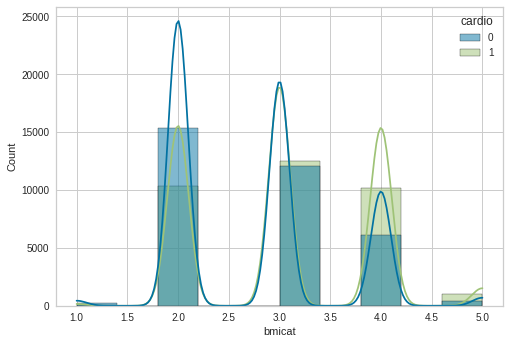

In [8]:
sns.histplot(data=df,x="bmicat",hue="cardio",kde=True,bins=10)
plt.show()

# When the BMI category increases, you can see from the histplot that the risk of cardiovascular disease also increases within the category.

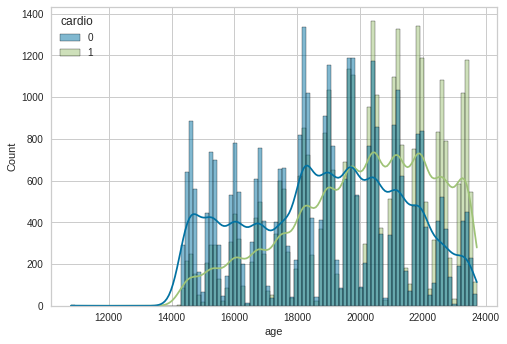

In [9]:
# I handle to age now
sns.histplot(data=df,x="age",hue="cardio",bins=100,kde=True)
plt.show()
# We can say with histplot; Cardiovascular diseases increases with age

In [10]:
# Finding the categorical years

df["year"] = np.round(df.age/365,2)
df.loc[(df.year <= 40), 'agecat'] = 1
df.loc[(df.year > 40)&(df.year<=45), 'agecat'] = 2
df.loc[(df.year > 40)&(df.year<=45), 'agecat'] = 3
df.loc[(df.year > 45)&(df.year<=50), 'agecat'] = 4
df.loc[(df.year > 50)&(df.year<=55), 'agecat'] = 5
df.loc[(df.year > 55)&(df.year<=60), 'agecat'] = 6
df.loc[(df.year > 60)&(df.year<=65), 'agecat'] = 7
df.loc[(df.year > 65)&(df.year<=70), 'agecat'] = 8
df.loc[(df.year >= 70), 'agecat'] = 9

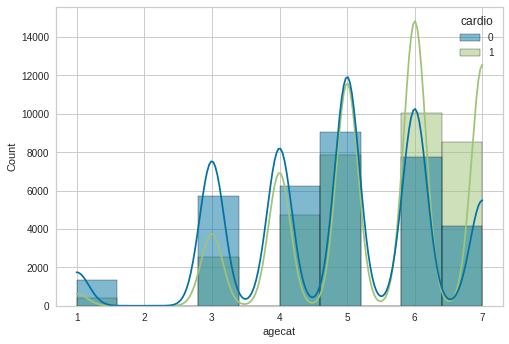

In [11]:

sns.histplot(data=df,x="agecat",hue="cardio",bins=10,kde=True)
plt.show()

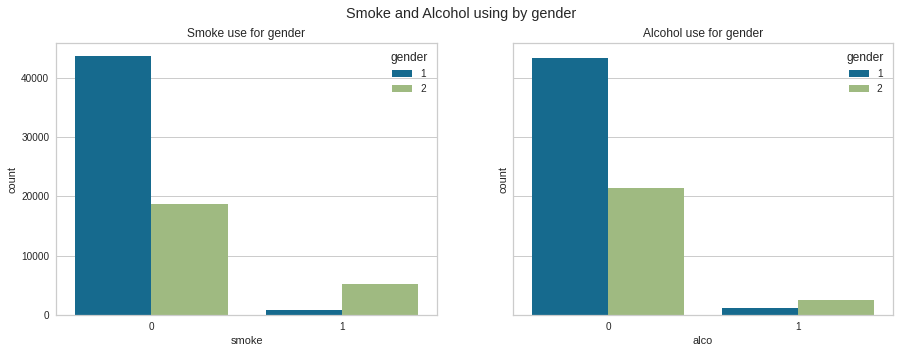

In [12]:
# I choose the AHA 2020 hypertension guideline for the categories

# We already know men have more uses smoke and alcohol rather than women
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Smoke and Alcohol using by gender')

# Bulbasaur
sns.countplot(ax=axes[0], x=df.smoke,hue=df.gender)
axes[0].set_title("Smoke use for gender")

# Charmander
sns.countplot(ax=axes[1], x=df.alco,hue=df.gender)
axes[1].set_title("Alcohol use for gender")
plt.show()
# Gender: 2 is must be men

In [13]:
df.gender.replace(1,"female",inplace=True)
df.gender.replace(2,"male",inplace=True)
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,bmicat,year,agecat
0,0,18393,male,167.0,61.0,110,80,1,1,0,0,1,0,21.87,2.0,50.39,5.0
1,1,20228,female,155.0,84.0,140,90,3,1,0,0,1,1,34.96,4.0,55.42,6.0
2,2,18857,female,164.0,63.0,130,70,3,1,0,0,0,1,23.42,2.0,51.66,5.0


In [14]:
# Some conditions are incompatible with normal life.

out_filter = ((df["ap_hi"]>180) | (df["ap_lo"]>150))
df = df[~out_filter]
out_filter2 = ((df["ap_hi"] < 60) | (df["ap_lo"] < 30))
df = df[~out_filter2]

# Some cases diastolic pressure is higher than systolic, it is impossible with normal physiologic condition. 
df = df[~(df['ap_lo']> df['ap_hi'])]

print(df.shape)

(66826, 17)


In [15]:
# Find the risk number
risk_number = []
for i in tqdm(range(len(df))):
    total = []
    if df.agecat.iloc[i]>8:
        total.append(1)
    if df.gluc.iloc[i]>1:
        total.append(1)
    if df.cholesterol.iloc[i]>1:
        total.append(1)
    if df.bmicat.iloc[i]>=3:
        total.append(1)
    if df.active.iloc[i]==0:
        total.append(1)
    if df.alco.iloc[i] == 1:
        total.append(1)
    if df.smoke.iloc[i] == 1:
        total.append(1)
    risk_number.append(np.sum(total))

df["risk_number"] = risk_number

hypertension_grade = []
for i in tqdm(range(len(df))):
    if df.ap_hi.iloc[i]<140 and df.ap_lo.iloc[i]<90:
        if df.risk_number.iloc[i] >=3:
            hypertension_grade.append(3)
        else:
            hypertension_grade.append(1)
    elif df.ap_hi.iloc[i]>=160 and df.ap_lo.iloc[i]>=100:
        if df.risk_number.iloc[i]>0:
            hypertension_grade.append(3)
        else:
            hypertension_grade.append(2)
    else:
        if df.risk_number.iloc[i] < 1:
            hypertension_grade.append(1)
        elif df.risk_number.iloc[i] >= 3:
            hypertension_grade.append(3)
        else:
            hypertension_grade.append(2)


df["hyper_tension_gr"] = hypertension_grade

df.head()

100%|██████████| 66826/66826 [00:02<00:00, 24904.66it/s]


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,bmicat,year,agecat,risk_number,hyper_tension_gr
0,0,18393,male,167.0,61.0,110,80,1,1,0,0,1,0,21.87,2.0,50.39,5.0,0.0,1
1,1,20228,female,155.0,84.0,140,90,3,1,0,0,1,1,34.96,4.0,55.42,6.0,2.0,2
2,2,18857,female,164.0,63.0,130,70,3,1,0,0,0,1,23.42,2.0,51.66,5.0,2.0,1
3,3,17623,male,168.0,81.0,150,100,1,1,0,0,1,1,28.70,3.0,48.28,4.0,1.0,2
4,4,17474,female,155.0,55.0,100,60,1,1,0,0,0,0,22.89,2.0,47.87,4.0,1.0,1


In [16]:
# Let's the drop dependent columns;
df.drop(columns=["id","age","height","weight","ap_hi","ap_lo","bmi","year","risk_number"],inplace=True)
df.head(3)

,gender,cholesterol,gluc,smoke,alco,active,cardio,bmicat,agecat,hyper_tension_gr
0,male,1,1,0,0,1,0,2.0,5.0,1
1,female,3,1,0,0,1,1,4.0,6.0,2
2,female,3,1,0,0,0,1,2.0,5.0,1


In [17]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df.gender = le.fit_transform(df.gender)
df.head(3)

,gender,cholesterol,gluc,smoke,alco,active,cardio,bmicat,agecat,hyper_tension_gr
0,1,1,1,0,0,1,0,2.0,5.0,1
1,0,3,1,0,0,1,1,4.0,6.0,2
2,0,3,1,0,0,0,1,2.0,5.0,1


In [18]:
df = pd.get_dummies(df,columns=['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'bmicat',
       'agecat', 'hyper_tension_gr'],drop_first=True)
df.head()

,cardio,gender_1,cholesterol_2,cholesterol_3,gluc_2,gluc_3,smoke_1,alco_1,active_1,bmicat_2.0,bmicat_3.0,bmicat_4.0,bmicat_5.0,agecat_3.0,agecat_4.0,agecat_5.0,agecat_6.0,agecat_7.0,hyper_tension_gr_2,hyper_tension_gr_3
0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0
1,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0
2,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
3,1,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0


In [19]:
X = df.copy()
y = X.cardio
X.drop(columns="cardio",inplace=True)
X.shape,y.shape

((66826, 19), (66826,))

In [20]:
all_preprocessed_data = X.copy()
all_preprocessed_data["target"] = y
all_preprocessed_data.to_csv("all_preprocessed_data.csv",index=False)

In [21]:
from sklearn.model_selection import StratifiedKFold, train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
y,
test_size = 0.5,
random_state=42,
stratify=y)
#train = pd.concat([X_train,y_train],axis=1)
#test = pd.concat([X_test,y_test],axis=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((33413, 19), (33413, 19), (33413,), (33413,))

In [22]:
data = X_train.copy()
data["target"] = y_train
data.shape

(33413, 20)

In [23]:
s = setup(data,
target='target',
categorical_features = ['gender_1', 'cholesterol_2', 'cholesterol_3', 'gluc_2', 'gluc_3',
       'smoke_1', 'alco_1', 'active_1', 'bmicat_2.0', 'bmicat_3.0',
       'bmicat_4.0', 'bmicat_5.0', 'agecat_3.0', 'agecat_4.0', 'agecat_5.0',
       'agecat_6.0', 'agecat_7.0', 'hyper_tension_gr_2', 'hyper_tension_gr_3'],
session_id=42,
train_size = 0.9, 
data_split_shuffle=True,
remove_multicollinearity=True,
remove_outliers=True,
normalize=True,
normalize_method="robust",
use_gpu=False,
fix_imbalance=True)

,Description,Value
0,session_id,42
1,Target,target
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(33413, 20)"
5,Missing Values,False
6,Numeric Features,0
7,Categorical Features,19
8,Ordinal Features,False
9,High Cardinality Features,False


In [24]:
best_models = compare_models(cross_validation=True,
                            fold=5,
                            sort="Accuracy",
                            n_select=1,
                            )

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.6998,0.7527,0.6561,0.7053,0.6798,0.3979,0.3989,2.3200
lightgbm,Light Gradient Boosting Machine,0.6974,0.7536,0.6579,0.7007,0.6786,0.3932,0.3939,1.7100
lr,Logistic Regression,0.6966,0.7520,0.6162,0.7191,0.6635,0.3903,0.3943,2.6420
ridge,Ridge Classifier,0.6965,0.0000,0.5972,0.7290,0.6564,0.3893,0.3957,1.5940
ada,Ada Boost Classifier,0.6965,0.7512,0.6009,0.7268,0.6578,0.3895,0.3952,1.8960
lda,Linear Discriminant Analysis,0.6965,0.7516,0.5972,0.7290,0.6564,0.3893,0.3957,1.5440
catboost,CatBoost Classifier,0.6965,0.7491,0.6486,0.7035,0.6749,0.3912,0.3924,10.4660
xgboost,Extreme Gradient Boosting,0.6951,0.7475,0.6515,0.7000,0.6748,0.3885,0.3894,3.1800
rf,Random Forest Classifier,0.6895,0.7405,0.6369,0.6976,0.6658,0.3770,0.3784,2.4160
et,Extra Trees Classifier,0.6886,0.7387,0.6270,0.7004,0.6616,0.3749,0.3769,2.2660


In [25]:
best_model = create_model(estimator="gbc",
            fold=5,
            cross_validation=True,
            )

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6990,0.7527,0.6595,0.7025,0.6803,0.3964,0.3971
1,0.6918,0.7464,0.6537,0.6940,0.6732,0.3821,0.3827
2,0.6970,0.7551,0.6565,0.7007,0.6778,0.3924,0.3932
3,0.7077,0.7580,0.6539,0.7187,0.6848,0.4134,0.4150
4,0.7035,0.7515,0.6568,0.7106,0.6827,0.4052,0.4063
Mean,0.6998,0.7527,0.6561,0.7053,0.6798,0.3979,0.3989
Std,0.0054,0.0039,0.0021,0.0086,0.0040,0.0107,0.0111


In [27]:
tuned_gbc = tune_model(estimator=best_model,
                       round=10,
                       fold=10,
                       optimize="AUC",
                       search_library="optuna",
                       search_algorithm="tpe",
                       choose_better=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6975848792,0.7557416188,0.6469740634,0.7059748428,0.6751879699,0.3932852703,0.3945965735
1,0.6989849492,0.7503680776,0.6707492795,0.6979010495,0.6840558413,0.3968386452,0.3971235561
2,0.7003850193,0.7556305146,0.6611391492,0.7037605526,0.6817843866,0.3992367117,0.3999322998
3,0.6800840042,0.7377580448,0.6387887527,0.6820631255,0.6597170514,0.3584784679,0.3591642297
4,0.7038851943,0.7666063397,0.6625811103,0.7085582113,0.6847988077,0.4061823301,0.4069952426
5,0.6881344067,0.7458239532,0.6647440519,0.6839762611,0.6742230347,0.3752460092,0.3753863945
6,0.7143857193,0.7655773485,0.6791636626,0.7174409749,0.6977777778,0.4274265050,0.4280038778
7,0.7013305322,0.7499849080,0.6467195386,0.7119047619,0.6777483944,0.4006365215,0.4022412951
8,0.7013305322,0.7499586504,0.6496034607,0.7105678233,0.6787193974,0.4007332394,0.4021410541


In [28]:
prediction = predict_model(tuned_gbc,X_test)

In [29]:
def model_eval(prediction,test):
    print("Classification Report: ")
    print(classification_report(test,prediction))
    print('Train Accuracy score: {0:0.2f}'.format(accuracy_score(test, prediction)))
    print('Train ROC AUC score: {0:0.2f}'.format(roc_auc_score(test, prediction)))


model_eval(prediction.Label,y_test)


Classification Report: 
              precision    recall  f1-score   support

           0       0.70      0.72      0.71     16943
           1       0.70      0.68      0.69     16470

    accuracy                           0.70     33413
   macro avg       0.70      0.70      0.70     33413
weighted avg       0.70      0.70      0.70     33413

Train Accuracy score: 0.70
Train ROC AUC score: 0.70


In [ ]:
evaluate_model(tuned_gbc)

In [31]:
save_model(tuned_gbc,
           "code")

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['gender_1',
                                                             'cholesterol_2',
                                                             'cholesterol_3',
                                                             'gluc_2', 'gluc_3',
                                                             'smoke_1', 'alco_1',
                                                             'active_1',
                                                             'bmicat_2.0',
                                                             'bmicat_3.0',
                                                             'bmicat_4.0',
                                                             'bmicat_5.0',
                                                             'agecat_3.0',
                                                             'agecat_4.0',
                                  

In [32]:
model = load_model("code/model.pkl")

Transformation Pipeline and Model Successfully Loaded


In [33]:
prediction = predict_model(model,X_test)
model_eval(prediction.Label,y_test)

Classification Report: 
              precision    recall  f1-score   support

           0       0.70      0.72      0.71     16943
           1       0.70      0.68      0.69     16470

    accuracy                           0.70     33413
   macro avg       0.70      0.70      0.70     33413
weighted avg       0.70      0.70      0.70     33413

Train Accuracy score: 0.70
Train ROC AUC score: 0.70
